# A simple harmonic oscillator
This notebook constructs and demonstrates a stable harmonic oscillator using two ensembles of SCTN neurons integrated into Nengo/NEF. The model doubles as a scaffold for future FPGA acceleration, with clear hand-off points where compute-heavy steps can be offloaded to hardware.

# Workflow
1.Imports & Config

2.FPGA Classes

3.Simulation Parameters

4.Model Definition

5.Run Simulation

## Imports

In [56]:
%matplotlib inline

In [57]:
from copy import deepcopy
from nengo.dists import Distribution
from nengo import Probe

from nengo.base import NengoObject
from nengo.dists import DistOrArrayParam, ScatteredHypersphere, Uniform
from nengo.params import (IntParam, NumberParam, Unconfigurable, Default,StringParam,BoolParam)
from nengo.exceptions import ReadonlyError, NetworkContextError, ConfigError, NotAddedToNetworkWarning
from nengo.ensemble import Neurons
from nengo.solvers import LstsqL2
from nengo.utils.numpy import clip  # pylint: disable=import-outside-toplevel


class FPGAEnsemble(NengoObject):
    """A purely-FPGA-backed “ensemble” with LIF parameters, no CPU LIF build."""
    # --- core “ensemble” parameters ---
    n_neurons = IntParam("n_neurons", low=1)
    dims_in = IntParam("dims_in", low=1)
    dims_out = IntParam("dims_out", low=0)
    dims_recur = IntParam("dims_recur", low=0, default=0)

    # --- tuning curves parameters ---
    encoders = DistOrArrayParam("encoders", default=ScatteredHypersphere(surface=True),
                                sample_shape=("n_neurons", "dimensions"), )
    intercepts = DistOrArrayParam("intercepts", default=Uniform(-1.0, 0.9), optional=True,
                                  sample_shape=("n_neurons",), )
    max_rates = DistOrArrayParam("max_rates", default=Uniform(200, 400), optional=True, sample_shape=("n_neurons",), )


    # --- decoders parameters ---
    eval_points = DistOrArrayParam("eval_points", default=ScatteredHypersphere(), sample_shape=("*", "dimensions"), )
    n_eval_points = IntParam("n_eval_points", default=None, optional=True, )
    radius = NumberParam("radius", low=0, default=1.0)

    # --- neuron model parameters ---
    theta = NumberParam("theta", default=0.0, readonly=True)
    reset_to = NumberParam("reset_to", default=0.0, readonly=True)
    min_clip = NumberParam("min_clip", default=-524287.0, readonly=True)
    max_clip = NumberParam("max_clip", default=524287.0, readonly=True)
    leakage_factor = IntParam("leakage_factor", default=0, low=0, readonly=True)
    leakage_period = IntParam("leakage_period", default=1, low=1, readonly=True)
    threshold_pulse = NumberParam("threshold_pulse", default=0.0, readonly=True)
    activation_function_str = StringParam("activation_function_str", default="IDENTITY", readonly=True)
    membrane_should_reset = BoolParam("membrane_should_reset", default=True, readonly=True)
    amplitude = NumberParam("amplitude", default=1.0, low=0.000001, readonly=True)
    identity_const = NumberParam("identity_const", default=32767.0, readonly=True)
    gaussian_rand_order = IntParam("gaussian_rand_order", default=8, low=1, readonly=True)

    # --- optional / unused on FPGA ---
    # noise          = NumberParam("noise",    low=0, default=0.0)
    # normalize_encoders = NumberParam("normalize_encoders", low=0, default=0.0)

    def __init__(
            self,
            # --- core “ensemble” parameters ---
            n_neurons,
            dims_in,
            dims_out,
            dims_recur=0,  # to do add dims_recur as nengo does
            # --- tuning curves parameters ---
            encoders=Default,
            intercepts=Default,
            max_rates=Default,
            gain = Default,
            bias = Default,
            decoders=Default,
            # --- decoders parameters ---
            radius=1.0,
            n_eval_points=Default,
            eval_points=Default,
            function=None,
            reg=1.0,
            # --- neuron model parameters ---
            theta=Unconfigurable,
            reset_to=Unconfigurable,
            min_clip=Unconfigurable,
            max_clip=Unconfigurable,
            leakage_factor=Unconfigurable,
            leakage_period=Unconfigurable,
            threshold_pulse=Unconfigurable,
            activation_function="BINARY",
            membrane_should_reset=Unconfigurable,
            amplitude=1.0,
            identity_const=Unconfigurable,
            gaussian_rand_order=Unconfigurable,
            initial_state=None,
            # noise=Default,
            # normalize_encoders=Default,
            seed=Default,
            label=Default, ):
        super().__init__(label=label, seed=seed)  # registers all the Params above

        # nothing else: this object just holds parameters for your FPGA builder

        # Ensure critical values are provided
        if any(v is None for v in [n_neurons, dims_in, dims_out]):
            raise ValueError(
                f"Missing required parameters: n_neurons={n_neurons}, dims_in={dims_in}, dims_out={dims_out}")

        # Check for maximum supported values
        if n_neurons > 128:
            raise AttributeError(f"n_neurons={n_neurons} exceeds maximum supported 128.")
        if radius <= 0:
            raise ValueError(f"radius must be > 0 (got radius={radius}).")

        self.stopped = False
        if seed is Default:
            seed = 42  # to do add nengo seed selection
        rng = np.random.RandomState(seed)  # (or np.random.default_rng() in newer NumPy)
        data_t = np.float32

        # sample/cast parameters in one call each
        encoders = self._samp(encoders, "encoders", n_neurons, dims_in, data_t, rng)
        intercepts = self._samp(intercepts, "intercepts", n_neurons, 1, data_t, rng)
        max_rates = self._samp(max_rates, "max_rates", n_neurons, 1, data_t, rng)

        intercepts = intercepts.ravel()
        max_rates = max_rates.ravel()


        # 4) eval_points
        if eval_points is Default:
            if n_eval_points is Default:
                n_eval_points = max(clip(500 * dims_in, 750, 2500), 2 * n_neurons)
            eval_points = type(self).eval_points.default.sample(n_eval_points, dims_in, rng)
            eval_points *= radius  # scale by ensemble radius
            print(eval_points.shape)
        else:
            if (n_eval_points is None) or (eval_points.shape[0] != n_eval_points) or (
                    eval_points.shape[1] != n_neurons):
                pass
        eval_points = np.array(eval_points, dtype=data_t)
        # ... (קוד קיים לאתחול encoders, intercepts, max_rates) ...
        print(f"DEBUG FPGAEnsemble '{self.label}': Initializing with:")
        # print(f"  Encoders (sample):\n{encoders[:5,:] if encoders.ndim > 1 else encoders[:5]}") # אם encoders הוא numpy array
        print(f"  Intercepts (sample): {intercepts.flatten()[:5]}")  # הדפס 5 ראשונים
        print(f"  Max_rates (sample): {max_rates.flatten()[:5]}")  # הדפס 5 ראשונים
        print(f"  Radius: {radius}")
        print(f"  Reg: {reg}")


        # Compute the gain & bias that turn eval_points into currents
        sctn = SCTNNeuronType(theta=theta,
                reset_to=reset_to,
                 min_clip=min_clip,
                 max_clip=max_clip,
                 leakage_factor=leakage_factor,
                 leakage_period=leakage_period,
                 threshold_pulse=threshold_pulse,
                 activation_function=activation_function,
                 membrane_should_reset=membrane_should_reset,
                 amplitude=amplitude,
                 identity_const=identity_const,
                 gaussian_rand_order=gaussian_rand_order,
                 initial_state=initial_state)

        self.neuron_type = sctn
        if gain is Default or bias is Default:

            gain, bias = self.neuron_type.gain_bias(max_rates, intercepts)


        self.gain = np.asarray(gain).ravel()
        self.bias = np.asarray(bias).ravel()





        # Compute the activity matrix A: shape (n_eval_points, n_neurons)
        x = np.dot(eval_points, encoders.T / radius).astype(dtype=data_t, copy=False)
        A = self.neuron_type.rates(x, gain, bias)  # or use built_ens_activities utilities to get A more directly  # to change in SCTN


        if function is None:
            F = eval_points
        else:
            F = function(eval_points)

        # core “ensemble” parameters
        self.n_neurons = n_neurons
        self.dims_in = dims_in
        self.dimensions = dims_in
        self.dims_out = dims_out
        self.dims_recur = dims_recur

        # tuning‐curve parameters
        self.encoders = encoders
        self.intercepts = intercepts
        self.max_rates = max_rates
        self.output_signal = None
        # neuron model parameters

        self.theta = theta
        self.reset_to = reset_to
        self.min_clip = min_clip
        self.max_clip = max_clip
        self.leakage_factor = leakage_factor
        self.leakage_period = leakage_period
        self.threshold_pulse = threshold_pulse
        self.activation_function_str = str(activation_function)
        self.membrane_should_reset = membrane_should_reset
        self.amplitude = amplitude
        self.identity_const = identity_const
        self.gaussian_rand_order = gaussian_rand_order

        # decoder parameters
        self.decoders, _ = LstsqL2(reg=reg)(A, F, rng=rng)  # returns (D, extra)

        return

    # helper to sample or cast
    def _samp(self, param_value, param_name, n_neurons, dims_in, data_t, rng):
        # 1. First, handle the case where the value is the default
        if param_value is Default:
            param_value = getattr(type(self), param_name).default

        # 2. Now, check if the variable is a Distribution object
        if isinstance(param_value, Distribution):
            # If so, sample from it using .sample()
            return param_value.sample(n_neurons, dims_in, rng=rng).astype(data_t)
        else:
            # Otherwise, it is already an array and can be cast directly
            return np.array(param_value, dtype=data_t, copy=False)

    def stop(self):
        self.stopped = True

    def __del__(self, signum=None, frame=None):
        self.stop()

    def __getitem__(self, key):
        return ObjView(self, key)

    def __len__(self):
        return self.dims_in

    @property
    def neurons(self):
        """A direct interface to the neurons in the ensemble."""
        return Neurons(self)

    @neurons.setter
    def neurons(self, dummy):
        raise ReadonlyError(attr="neurons", obj=self)

    @property
    def size_in(self):
        """The dimensionality of the ensemble."""
        return self.dims_in

    @property
    def size_out(self):
        """The dimensionality of the ensemble."""
        return self.dims_out

In [58]:

from nengo.config import Config

from nengo.utils.threading import ThreadLocalStack
from nengo.params import StringParam, IntParam


class FPGANetwork:
    context = ThreadLocalStack(maxsize=100)  # static stack of Network objects

    label = StringParam("label", optional=True, readonly=False)
    seed = IntParam("seed", optional=True, readonly=False)

    def __init__(self, label=None, seed=None, add_to_container=None):
        self.label = label
        self.seed = seed
        self._config = self.default_config()

        self._objects = {FPGAEnsemble: [], Node: [], Connection: [], FPGANetwork: []}
        self._ensembles = self.objects[FPGAEnsemble]
        self._nodes = self.objects[Node]
        self._connections = self.objects[Connection]
        self._networks = self.objects[FPGANetwork]

        # By default, we want to add to the current context, unless there is
        # no context; i.e., we're creating a top-level network.
        if add_to_container is None:
            add_to_container = len(FPGANetwork.context) > 0

        if add_to_container:
            FPGANetwork.add(self)

    @staticmethod
    def add(obj):
        """Add the passed object to ``Network.context``."""
        if len(FPGANetwork.context) == 0:
            raise NetworkContextError(
                f"'{obj}' must either be created inside a ``with network:`` "
                "block, or set add_to_container=False in the object's "
                "constructor."
            )
        network = FPGANetwork.context[-1]
        if not isinstance(network, FPGANetwork):
            raise NetworkContextError(f"Current context ({network}) is not a network")
        for cls in type(obj).__mro__:
            if cls in network.objects:
                network.objects[cls].append(obj)
                break
        else:
            raise NetworkContextError(
                f"Objects of type '{type(obj).__name__}' cannot be added to networks."
            )

    @staticmethod
    def default_config():
        """Constructs a `~.Config` object for setting defaults."""
        return Config(Connection, FPGAEnsemble, Node, Probe)

    def _all_objects(self, object_type):
        """Returns a list of all objects of the specified type."""
        # Make a copy of this network's list
        objects = list(self.objects[object_type])
        for subnet in self.networks:
            objects.extend(subnet._all_objects(object_type))
        return objects

    @property
    def all_objects(self):
        """(list) All objects in this network and its subnetworks."""
        objects = []
        for object_type in self.objects:
            objects.extend(self._all_objects(object_type))
        return objects

    @property
    def all_ensembles(self):
        """(list) All ensembles in this network and its subnetworks."""
        return self._all_objects(FPGAEnsemble)

    @property
    def all_nodes(self):
        """(list) All nodes in this network and its subnetworks."""
        return self._all_objects(Node)

    @property
    def all_networks(self):
        """(list) All networks in this network and its subnetworks."""
        return self._all_objects(FPGANetwork)

    @property
    def all_connections(self):
        """(list) All connections in this network and its subnetworks."""
        return self._all_objects(Connection)

    @property
    def all_probes(self):
        """(list) All probes in this network and its subnetworks."""
        return self._all_objects(Probe)

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, _):
        raise ReadonlyError(attr="objects", obj=self)

    @property
    def ensembles(self):
        return self._ensembles

    @ensembles.setter
    def ensembles(self, _):
        raise ReadonlyError(attr="ensembles", obj=self)

    @property
    def nodes(self):
        return self._nodes

    @nodes.setter
    def nodes(self, _):
        raise ReadonlyError(attr="nodes", obj=self)

    @property
    def networks(self):
        return self._networks

    @networks.setter
    def networks(self, _):
        raise ReadonlyError(attr="networks", obj=self)

    @property
    def connections(self):
        return self._connections

    @connections.setter
    def connections(self, _):
        raise ReadonlyError(attr="connections", obj=self)

    @property
    def config(self):
        """(`.Config`) Configuration for this network."""
        return self._config

    @config.setter
    def config(self, _):
        raise ReadonlyError(attr="config", obj=self)

    @property
    def n_neurons(self):
        """(int) Number of neurons in this network, including subnetworks."""
        return sum(ens.n_neurons for ens in self.all_ensembles)

    def __contains__(self, obj):
        return type(obj) in self.objects and obj in self.objects[type(obj)]

    def __enter__(self):
        FPGANetwork.context.append(self)
        self._config.__enter__()
        return self

    def __exit__(self, dummy_exc_type, dummy_exc_value, dummy_tb):
        if len(FPGANetwork.context) == 0:
            raise NetworkContextError(
                "Network.context in bad state; was empty when "
                "exiting from a 'with' block."
            )

        config = Config.context[-1]
        if config is not self._config:
            raise ConfigError(
                "Config.context in bad state; was expecting "
                f"current context to be {self._config!r} but instead got "
                f"{config!r}."
            )

        network = FPGANetwork.context.pop()
        if network is not self:
            raise NetworkContextError(
                "Network.context in bad state; was expecting current context "
                f"to be '{self}' but instead got '{network}'."
            )

        self._config.__exit__(dummy_exc_type, dummy_exc_value, dummy_tb)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["label"] = self.label
        state["seed"] = self.seed
        return state

    def __setstate__(self, state):
        for k, v in state.items():
            setattr(self, k, v)
        if len(FPGANetwork.context) > 0:
            warnings.warn(NotAddedToNetworkWarning(self))

    def __str__(self):
        label_txt = (
            f'"{self.label}"'
            if self.label is not None
            else f"(unlabeled) at 0x{id(self):x}"
        )
        return f"<{type(self).__name__} {label_txt}>"

    def __repr__(self):
        label_txt = f'"{self.label}"' if self.label is not None else "(unlabeled)"
        return f"<{type(self).__name__} {label_txt} at 0x{id(self):x}>"

    def copy(self, add_to_container=None):
        with warnings.catch_warnings():
            # We warn when copying since we can't change add_to_container.
            # However, we deal with it here, so we ignore the warning.
            warnings.simplefilter("ignore", category=NotAddedToNetworkWarning)
            c = deepcopy(self)
        if add_to_container is None:
            add_to_container = len(FPGANetwork.context) > 0
        if add_to_container:
            FPGANetwork.add(c)
        return c




In [59]:
"""
Unified FPGA / software simulator for Nengo-style networks.

▪ If ``use_fpga=True``  (default) it streams inputs through the AXI-DMA
  interfaces and lets the HDL kernel run every time-step.
▪ If ``use_fpga=False`` it bypasses all FPGA hardware and instead calls
  the Python ``step`` method of the neuron type for every ensemble.
"""

from collections.abc import Mapping
import logging

import warnings
from nengo.base import ObjView

import numpy as np
from nengo.exceptions import SimulatorClosed, ValidationError
from nengo.synapses import Lowpass
from nengo.transforms import NoTransform



logger = logging.getLogger(__name__)


"""fpga_simulator_commented.py
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Annotated version of the original **FPGASimulator** implementation the user
provided.  All comments are purely explanatory and do **not** alter the
runtime behaviour of the code.

* Every added line begins with a single hash (#) so that the interpreter
  ignores it.
* Hebrew in‑line comments from the user are left intact but translated or
  clarified where helpful.
* No executable statements were modified — only comment blocks were added.
"""

# --------------------------- IMPORTS & TYPE ALIASES ---------------------------
# NOTE: The original snippet relied on many names assumed to be imported from
# the outer project (numpy as np, nengo, ValidationError, Lowpass, etc.).  You
# should keep those imports in the surrounding module.  No functional imports
# are introduced here; this comment section simply documents that dependency.


class FPGASimulator:
    """Hybrid (software / FPGA) simulator for Nengo‑like networks.

    Parameters
    ----------
    network : nengo.Network
        The network to simulate.  Must contain a *Node* labelled "input".
    time_in_seconds : float
        Total simulated duration.  Must be strictly positive.
    dt : float, optional (default 1e‑3)
        Integration time‑step.  Affects numerical accuracy and run time.
    seed : int or None, optional
        Random seed forwarded to RNGs in the network, if used.
    progress_bar : bool, optional
        Enable / disable terminal progress bar when running long sims.
    bitstream : str, optional
        Relative/absolute path to the FPGA bitstream to be loaded.
    use_fpga : bool, optional
        Select FPGA backend; falls back to software if *False* or if the
        required PYNQ components are unavailable.
    data_t : numpy dtype (default numpy.float64)
        Precision of all *simulation* arrays (state, filters, etc.).

    Notes
    -----
    • A context‑manager interface (``with FPGASimulator(...) as sim: ...``)
      ensures DMA channels are released automatically.
    • The class purposefully stores *full* history arrays for plotting.
      Streaming to disk would reduce memory for long runs but is beyond the
      scope here.
    """

    # ───────────────────────────── INITIALISATION ──────────────────────────────
    def __init__(
        self,
        network,
        time_in_seconds,
        *,
        dt=0.001,
        seed=None,
        progress_bar=True,
        bitstream="bitstream.bit",
        use_fpga=True,
        data_t=np.float64,
    ):
        # --- Basic argument validation ---------------------------------------
        if time_in_seconds <= 0:
            # Raise a *ValidationError* (defined elsewhere) if simulation time
            # was not specified as a strictly positive value.
            raise ValidationError(
                f"Must be positive (got {time_in_seconds:g})",
                attr="time_in_seconds",
            )

        # Store core configuration -------------------------------------------
        self._network = network
        self._conns = list(network.objects.get(Connection, []))  # All synapses
        self.use_fpga = bool(use_fpga)  # Force bool in case a truthy object
        self.dt = float(dt)
        self.data_t = data_t
        self.closed = False  # Tracks whether resources were released

        # Pre‑compute global time vector (first step starts at 1×dt) -----------
        # Integer rounding helps avoid accumulated floating‑point drift when
        # dt * N ≃ time_in_seconds, although it can shift the *exact* stop
        # time by ≤ 0.5*dt.
        self.N = int(round(time_in_seconds / dt))
        self.time_vec = np.arange(1, self.N + 1) * dt

        # Locate the driving node labelled "input" ---------------------------
        # Convention: the network must expose a single *Node* whose .label is
        # literally the string "input".  If not found, `next(...)` will raise
        # StopIteration — no try/except added so that mis‑configurations fail
        # loudly.
        self.input_node = next(
            n for n in network.objects.get(Node, []) if n.label == "input"
        )

        # Pre‑evaluate the input function for every time‑step so we can access
        # it O(1) during the main loop.
        self.input_node.output_signal = np.asarray(
            [self.input_node.output(t) for t in self.time_vec],
            dtype=data_t,
        )
        self.unfilt = None  # (Legacy) placeholder for unfiltered input traces

        # --------------------------------------------------------------------
        # Construct per‑connection PSC (post‑synaptic current) *Lowpass* filter
        # objects.  State arrays are initialised later in _run_software().
        # --------------------------------------------------------------------
        self._psc_filters = {}
        for conn in self._conns:
            # Only connections with an actual synapse need a PSC filter.
            if conn.synapse is not None:
                self._psc_filters[conn] = Lowpass(tau=conn.synapse.tau)

        # ------------- FPGA‑specific resources (currently commented) ---------
        # Keeping this block as documentation for users who *do* want to run
        # on real hardware.  Overlay & DMA objects are created lazily so the
        # simulator can still be used in pure‑software mode without pynq.
        """
        if self.use_fpga:
            if Overlay is None:
                raise RuntimeError(
                    "pynq not installed but use_fpga=True. "
                    "Install pynq or set use_fpga=False."
                )
            bit = Overlay(os.path.join(os.getcwd(), bitstream))
            self.ip = bit.ensemble_0
            self.dma_0 = bit.axi_dma_0
            self.dma_1 = bit.axi_dma_1
            # Reusable DMA host buffer for input spikes / currents
            self.in_buf = allocate(shape=(self.N,), dtype=data_t, cacheable=True)
        """

        # Even in software mode we create *dummy* attributes so that other
        # methods can unconditionally reference `self.ip`, `self.dma_0`, etc.
        self.ip = self.dma_0 = self.dma_1 = None
        self.in_buf = None

        # -------------------- Ensemble‑specific state ------------------------
        # Dictionaries map each FPGAEnsemble → persistent arrays/filters.
        self._state = {}

        # History for decoded dynamics (after *dynamics* filter)
        self._ensemble_dynamics_history = {
            ens: np.zeros((self.N, ens.size_out), dtype=self.data_t)
            for ens in self._network.all_ensembles if isinstance(ens, FPGAEnsemble)
        }
        # History for plotting (after *plotting* filter, fixed small tau)
        self._ensemble_plotting_history = {
            ens: np.zeros((self.N, ens.size_out), dtype=self.data_t)
            for ens in self._network.all_ensembles if isinstance(ens, FPGAEnsemble)
        }

        # Construct the two classes of filters per ensemble -------------------
        self._dynamics_filters = {}
        self._plotting_filters = {}
        plotting_tau = 0.03  # Always use small tau for UI plots

        for ens in self._network.all_ensembles:
            if isinstance(ens, FPGAEnsemble):
                # 1) Plotting filter (fixed tau)
                self._plotting_filters[ens] = Lowpass(tau=plotting_tau, method="euler")

                # 2) Dynamics filter — tau pulled from any recurrent conn
                dynamics_tau = 0.005  # Fallback if no recurrent connection
                for conn in self._conns:
                    if conn.pre == ens and conn.post == ens and conn.synapse is not None:
                        dynamics_tau = conn.synapse.tau  # Could be 0.1 or 0.3
                        break
                self._dynamics_filters[ens] = Lowpass(tau=dynamics_tau, method="euler")

    # ───────────────────────────── PUBLIC API ─────────────────────────────────
    def run(self):
        """Simulate the network for the duration passed to ``__init__``."""
        # Hardware backend disabled for now; always fall back to pure Python.
        """
        if self.use_fpga:
            return self._run_fpga()
        """
        return self._run_software()

    def close(self):
        """Explicitly release DMA channels & hardware resources."""
        if self.closed:
            return  # Allow idempotent calls

        if self.use_fpga and self.ip is not None:
            # Tell the kernel to stop; if `self.ip` is None we're in SW mode.
            self.ip.register_map.CTRL.AP_START = 0
            # Gracefully shut down DMA engines
            self.dma_0.sendchannel.stop()
            self.dma_1.recvchannel.stop()
            # Dump some status bits for post‑mortem debugging
            ctrl = self.ip.read(0x00)
            logger.debug(
                "[FPGA STATUS] AP_START=%d  AP_DONE=%d  AP_IDLE=%d",
                ctrl & 1,
                (ctrl >> 1) & 1,
                (ctrl >> 2) & 1,
            )

        self.closed = True
        logger.info("FPGA simulator closed.")

    # Context‑manager helpers -----------------------------------------------
    def __enter__(self):
        if self.closed:
            raise SimulatorClosed("Cannot re-open after simulator is closed")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

    def __del__(self):
        # Warn if the user forgot to call .close(); helps avoid resource leaks
        if not self.closed:
            warnings.warn(
                "Simulator was garbage-collected without close(); resources may leak.",
                ResourceWarning,
            )

    # ───────────────────────── INTERNAL: SOFTWARE BACKEND ─────────────────────
    # Helper ------------------------------------------------------------------
    def _get_signal_for_pre(self, pre_object, k_current_step, default_size_out=1):
        """Return the signal emitted by *pre_object* at time‑step *k*.

        Handles Nodes, FPGAEnsembles, and ObjViews derived from either.  Falls
        back to a zero array of *default_size_out* if the requested signal is
        not yet available (e.g., k == 0 for ensembles).
        """
        # --- Fast‑path: driving input node -----------------------------------
        if pre_object == self.input_node:
            if k_current_step < self.input_node.output_signal.shape[0]:
                # If the input is multidimensional, slice row k; else scalar.
                return (
                    self.input_node.output_signal[k_current_step, :]
                    if self.input_node.output_signal.ndim > 1
                    else self.input_node.output_signal[k_current_step]
                )
            # Safety net: requested k beyond available signal → zeros.
            return np.zeros(
                self.input_node.size_out if hasattr(self.input_node, "size_out") else default_size_out,
                dtype=self.data_t,
            )

        # --- Ensemble case ----------------------------------------------------
        elif isinstance(pre_object, FPGAEnsemble):
            # At k == 0 the ensemble has not produced spikes yet → zeros.
            if k_current_step == 0:
                return np.zeros(pre_object.size_out, dtype=self.data_t)
            # Otherwise return the previous decoded output.
            return self._ensemble_dynamics_history[pre_object][k_current_step - 1, :]

        # --- ObjView: could target either Node or Ensemble -------------------
        elif isinstance(pre_object, ObjView):
            parent_object = pre_object.obj  # The underlying Node/Ensemble

            # Determine selection (slice / indices) ---------------------------
            sel = None
            if hasattr(pre_object, "indices"):
                sel = pre_object.indices
            elif hasattr(pre_object, "slice"):
                sel = pre_object.slice
            elif hasattr(pre_object, "_slice"):
                sel = pre_object._slice
            else:
                raise AttributeError(f"ObjView {pre_object} has no 'indices' or 'slice' attribute")

            # --- Parent is the input node -----------------------------------
            if parent_object == self.input_node:
                if k_current_step < self.input_node.output_signal.shape[0]:
                    full_signal = (
                        self.input_node.output_signal[k_current_step, :]
                        if self.input_node.output_signal.ndim > 1
                        else self.input_node.output_signal[k_current_step]
                    )
                    return full_signal[sel]

                # Out‑of‑range → zeros with slice‑appropriate length ----------
                slice_size = 1  # Conservative default
                if isinstance(sel, slice):
                    start = sel.start if sel.start is not None else 0
                    stop = sel.stop if sel.stop is not None else (
                        parent_object.size_out if hasattr(parent_object, "size_out") else 1
                    )
                    step = sel.step if sel.step is not None else 1
                    slice_size = len(range(start, stop, step))
                elif isinstance(sel, (list, np.ndarray)):
                    slice_size = len(sel)
                return np.zeros(slice_size, dtype=self.data_t)

            # --- Parent is an Ensemble --------------------------------------
            elif isinstance(parent_object, FPGAEnsemble):
                if k_current_step == 0:
                    # Ensemble has no history at k==0 → zeros of slice length
                    slice_size = 1
                    if isinstance(sel, slice):
                        start = sel.start if sel.start is not None else 0
                        stop = sel.stop if sel.stop is not None else (
                            parent_object.size_out if hasattr(parent_object, "size_out") else 1
                        )
                        step = sel.step if sel.step is not None else 1
                        slice_size = len(range(start, stop, step))
                    elif isinstance(sel, (list, np.ndarray)):
                        slice_size = len(sel)
                    return np.zeros(slice_size, dtype=self.data_t)
                # Return the previous decoded output and slice it.
                parent_signal_history_km1 = self._ensemble_dynamics_history[parent_object][k_current_step - 1, :]
                return parent_signal_history_km1[sel]

            # --- Unknown parent object --------------------------------------
            return np.zeros(default_size_out, dtype=self.data_t)

        # Fallback for unsupported *pre_object* types --------------------------
        return np.zeros(default_size_out, dtype=self.data_t)

    # -------------------------------------------------------------------------
    # Main software simulation loop -------------------------------------------
    def _run_software(self):
        """Pure‑Python backend using Euler α‑approximation for PSC filters."""

        # ---------------- 1. Reset / prepare per‑ensemble state --------------
        neuron_states = {}
        for ens in self._network.all_ensembles:
            if isinstance(ens, FPGAEnsemble):
                if isinstance(ens.neuron_type, nengo.LIF):
                    neuron_states[ens] = {
                        "voltage": np.zeros(ens.n_neurons, dtype=self.data_t),
                        "refractory_time": np.zeros(ens.n_neurons, dtype=self.data_t),
                    }
                elif isinstance(ens.neuron_type, SCTNNeuronType):
                    neuron_states[ens] = {
                        "voltage": np.full(ens.n_neurons, ens.neuron_type.reset_to, self.data_t),
                        "leakage_timer": np.zeros(ens.n_neurons, self.data_t),
                        "rand_gauss_var_state": np.zeros(ens.n_neurons, self.data_t),
                        "pn_generator_state": np.ones(ens.n_neurons, self.data_t),
                    }

        # Per‑step caches -----------------------------------------------------
        last_step_spikes = {ens: np.zeros(ens.n_neurons, self.data_t) for ens in self._network.all_ensembles}
        J_step_inputs = {ens: np.zeros(ens.n_neurons, dtype=self.data_t) for ens in self._network.all_ensembles}

        # PSC filter *state* (one array per connection) -----------------------
        psc_states = {}
        for conn in self._network.all_connections:
            if getattr(conn, "synapse", None) is not None:
                pre_obj = conn.pre.obj if isinstance(conn.pre, ObjView) else conn.pre
                if isinstance(pre_obj, FPGAEnsemble):
                    psc_states[conn] = np.zeros(pre_obj.n_neurons, dtype=self.data_t)
                elif isinstance(pre_obj, Node):
                    psc_states[conn] = np.zeros(conn.pre.size_out, dtype=self.data_t)

        # History of low‑pass‑filtered decoded values -------------------------
        outputs_history = {
            ens: np.zeros((self.N, ens.size_out), dtype=self.data_t)
            for ens in self._network.all_ensembles
        }
        output_lpf = Lowpass(tau=0.03)  # Global read‑out LPF

        # Build *incoming connections* map: ensemble → list[Connection] -------
        incoming_connections = {ens: [] for ens in self._network.all_ensembles}
        for conn in self._network.all_connections:
            if isinstance(conn.post, FPGAEnsemble):
                incoming_connections[conn.post].append(conn)

        # ---------------- 2. Main time‑step loop -----------------------------
        for k in range(self.N):
            # (a) Compute input currents J for every ensemble ----------------
            for ens_post, conns_in in incoming_connections.items():
                x_total_for_ens = np.zeros(ens_post.dims_in, dtype=self.data_t)
                for conn in conns_in:
                    pre = conn.pre
                    source_obj = pre.obj if isinstance(pre, ObjView) else pre
                    source_slice = pre.slice if isinstance(pre, ObjView) else slice(None)

                    # Handle Ensemble sources --------------------------------
                    if isinstance(source_obj, FPGAEnsemble):
                        source_spikes = last_step_spikes[source_obj]
                        filtered_signal = source_spikes
                        if conn.synapse is not None:
                            # Euler α‑approximation of exponential filter
                            alpha = self.dt / conn.synapse.tau
                            psc_states[conn] = (1 - alpha) * psc_states[conn] + alpha * source_spikes
                            filtered_signal = psc_states[conn]
                        x_value = np.dot(filtered_signal, source_obj.decoders)

                    # Handle Node sources ------------------------------------
                    elif isinstance(source_obj, Node):
                        node_output = source_obj.output_signal[k]
                        source_signal = node_output[source_slice]
                        filtered_signal = source_signal
                        if conn.synapse is not None:
                            alpha = self.dt / conn.synapse.tau
                            psc_states[conn] = (1 - alpha) * psc_states[conn] + alpha * source_signal
                            filtered_signal = psc_states[conn]
                        x_value = filtered_signal

                    else:
                        # If source type unknown, skip this connection
                        continue

                    # Apply transform matrix, unless it's an identity --------
                    if not isinstance(conn.transform, NoTransform):
                        T = conn.transform.sample() if hasattr(conn.transform, "sample") else conn.transform
                        x_value = np.dot(T, x_value)

                    x_total_for_ens += x_value.squeeze()



                J_step_inputs[ens_post] = np.dot(ens_post.encoders, x_total_for_ens) * ens_post.gain + ens_post.bias



            # (b) Update neuron state & generate spikes ----------------------
            for ens_post in self._network.all_ensembles:
                if not isinstance(ens_post, FPGAEnsemble):
                    continue

                spikes_output = np.zeros(ens_post.n_neurons, dtype=self.data_t)
                st = neuron_states[ens_post]  # Shortcut alias
                current_J = J_step_inputs[ens_post]

                if isinstance(ens_post.neuron_type, nengo.LIF):
                    ens_post.neuron_type.step(self.dt, current_J, spikes_output, st["voltage"], st["refractory_time"])
                elif isinstance(ens_post.neuron_type, SCTNNeuronType):
                    ens_post.neuron_type.step(
                        self.dt,
                        current_J,
                        spikes_output,
                        st["voltage"],
                        st["leakage_timer"],
                        st["rand_gauss_var_state"],
                        st["pn_generator_state"],
                    )

                # Optional debug voltage dump -------------------------------

                # Book‑keeping for next step --------------------------------
                last_step_spikes[ens_post] = spikes_output  # No .copy() needed

                # Decode spikes → function output, then low‑pass -------------
                decoded_output = np.dot(spikes_output, ens_post.decoders)
                outputs_history[ens_post][k, :] = output_lpf.filt(decoded_output, dt=self.dt).squeeze()

        # ---------------- 3. Wrap‑up -----------------------------------------
        for ens, history in outputs_history.items():
            ens.output_signal = history  # Attach back to ensemble for probes

        return outputs_history

    def _run_fpga(self,data_t=np.float32):
        """

        output_signal = None
        # iterate connections in the network
        for conn in self._conns:
            pre = conn.pre
            post = conn.post
            print("connn")
            print(conn)
            print(pre)
            print(post)

            n_neurons = post.n_neurons
            dims_in = post.dims_in
            tau = conn.synapse.tau  # tau time constatnt for lowpass filter

            # Allocate simulation buffers # Allocate placeholders for simulation buffers

            out_volt_buf = allocate(shape=(self.N * n_neurons,), dtype=data_t)
            out_spike_buf = allocate(shape=(self.N * n_neurons,), dtype=data_t)


            # aplly conection transform:
            T = conn.transform
            if isinstance(conn.transform, NoTransform):
                np.copyto(self.in_buf, pre.output_signal)
            else:
                T = conn.transform.sample()
                input_T = np.dot(pre.output_signal, T.T).squeeze()  # -> shape (n_steps, 1)
                np.copyto(self.in_buf, input_T)

            # write simulation timestep  to FPGA of first ensemble
            self.ip.register_map.NUM_NEURONS = int(n_neurons)
            self.ip.register_map.dt = int(data_t(self.dt).view(np.uint32))
            self.ip.register_map.tau_rc = int(data_t(post.tau_rc).view(np.uint32))
            self.ip.register_map.tau_ref = int(data_t(post.tau_ref).view(np.uint32))
            self.ip.register_map.min_voltage = int(data_t(post.min_voltage).view(np.uint32))

            # 9) Allocate contiguous buffers on the FPGA for per-neuron arrays

            inter_buf = allocate((n_neurons,), dtype=data_t)
            max_rates_buf = allocate((n_neurons,), dtype=data_t)
            enc_buf = allocate((n_neurons, dims_in), dtype=data_t)


            # 10) Copy Python-side arrays into the hardware buffers
            inter_buf[:] = post.intercepts
            max_rates_buf[:] = post.max_rates
            enc_buf[:, :] = post.encoders

            # 11) Point the IP core to the physical addresses of these buffers
            self.ip.register_map.intercepts_addr_1 = inter_buf.physical_address
            self.ip.register_map.max_rates_addr_1 = max_rates_buf.physical_address
            self.ip.register_map.encoders_addr_1 = enc_buf.physical_address

            self.dma_0.sendchannel.transfer(self.in_buf)
            self.dma_0.recvchannel.transfer(out_volt_buf)
            self.dma_1.recvchannel.transfer(out_spike_buf)

            # Trigger the FPGA kernel to start processing
            self.ip.register_map.CTRL.AP_START = 1
            # Wait for all DMA transfers to complete
            self.dma_0.sendchannel.wait()
            self.dma_0.recvchannel.wait()
            self.dma_1.recvchannel.wait()

            spike = out_spike_buf.reshape(-1, n_neurons)
            output_signal = spike @ post.decoders
            self.unfilt = output_signal  # could be remove when not displaied to user

            # LPF implementation in software
            if tau is None:
                post.output_signal = output_signal
            else:
                syn = Lowpass(tau=tau, method="euler")
                post.output_signal = syn.filt(output_signal, dt=self.dt)

        # Stop the FPGA kernel
        self.ip.register_map.CTRL.AP_START = 0
        return post.output_signal
    """
    # ─────────────────────────── SIMULATION-DATA VIEW ─────────────────────────
    class SimulationData(Mapping):
        """Lightweight *read‑only* wrapper around raw probe arrays."""

        def __init__(self, raw):
            self.raw = raw
            self._cache = {}

        def __getitem__(self, key):
            # Cache numpy views so repeated indexing is cheap.
            if key not in self._cache or len(self._cache[key]) != len(self.raw[key]):
                val = np.asarray(self.raw[key]) if isinstance(self.raw[key], list) else self.raw[key]
                val.setflags(write=False)  # Prevent accidental mutation
                self._cache[key] = val
            return self._cache[key]

        def __iter__(self):
            return iter(self.raw)

        def __len__(self):
            return len(self.raw)

        # Allow users to explicitly clear immutable views --------------------
        def reset(self):
            self._cache.clear()




## Step 1: Define simulations parameters

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo.connection import Connection
from nengo.node import Node

# ייבוא המחלקות המותאמות אישית מהקבצים המתאימים
from main.sctn import SCTNNeuronType

# --- 1. הגדרת פרמטרים לסימולציה ---
sim_run_time = 5.0
sim_dt = 1e-3
sim_n_neurons = 100
sim_tau = 0.1
sim_seed = 1771
sim_A = np.array([
    [1, 1],
    [-1, 1]
])

# פרמטרים עבור נוירון SCTN
sctn_params = {
    "theta": 0.0,
    "leakage_period": 10,
    "leakage_factor": 1,
    "threshold_pulse": 0.1,
    "reset_to": 0.0,
    "activation_function": "BINARY",
    "membrane_should_reset": True,
    "min_clip": -1000,
    "max_clip": 1000,
    "amplitude": 1.0,
    "identity_const": 32767.0,
    "gaussian_rand_order": 8
}


def input_func(t):
    if t < 0.1:
        return [1.0, 0.0]
    else:
        return [0.0, 0.0]




## Step 2: Create Software Model

(750, 1)
DEBUG FPGAEnsemble 'None': Initializing with:
  Intercepts (sample): [-0.6221994   0.3515497   0.50133353  0.15132396  0.7599717 ]
  Max_rates (sample): [104.40662  86.73236 145.83662 107.83004 116.24259]
  Radius: 2.0
  Reg: 1.0

SCTNNeuronType: CUSTOM gain_bias called for BINARY activation.
  Using settle_time=0.3s, sim_time=1.5s for rate calculations in gain_bias.
  gain_bias: Using J_nef search range approx [-65000.00, 65000.00] for activation 'BINARY'.

  Neuron 0: Target max_rate=104.41 Hz, intercept=-0.62
    _get_rate_for_NEF_current: J_nef=-65010.44, sim_time=1.5s (this may take a moment)...
    _get_rate_for_NEF_current: J_nef=-65010.44 -> rate=0.00 Hz
    _get_rate_for_NEF_current: J_nef=65052.20, sim_time=1.5s (this may take a moment)...
    _get_rate_for_NEF_current: J_nef=65052.20 -> rate=1000.00 Hz
  _find_J_nef: Target=0.10Hz. Range J_nef=[-65010.44 (rate 0.00Hz), 65052.20 (rate 1000.00Hz)]
    _get_rate_for_NEF_current: J_nef=-65010.44, sim_time=1.5s (this may

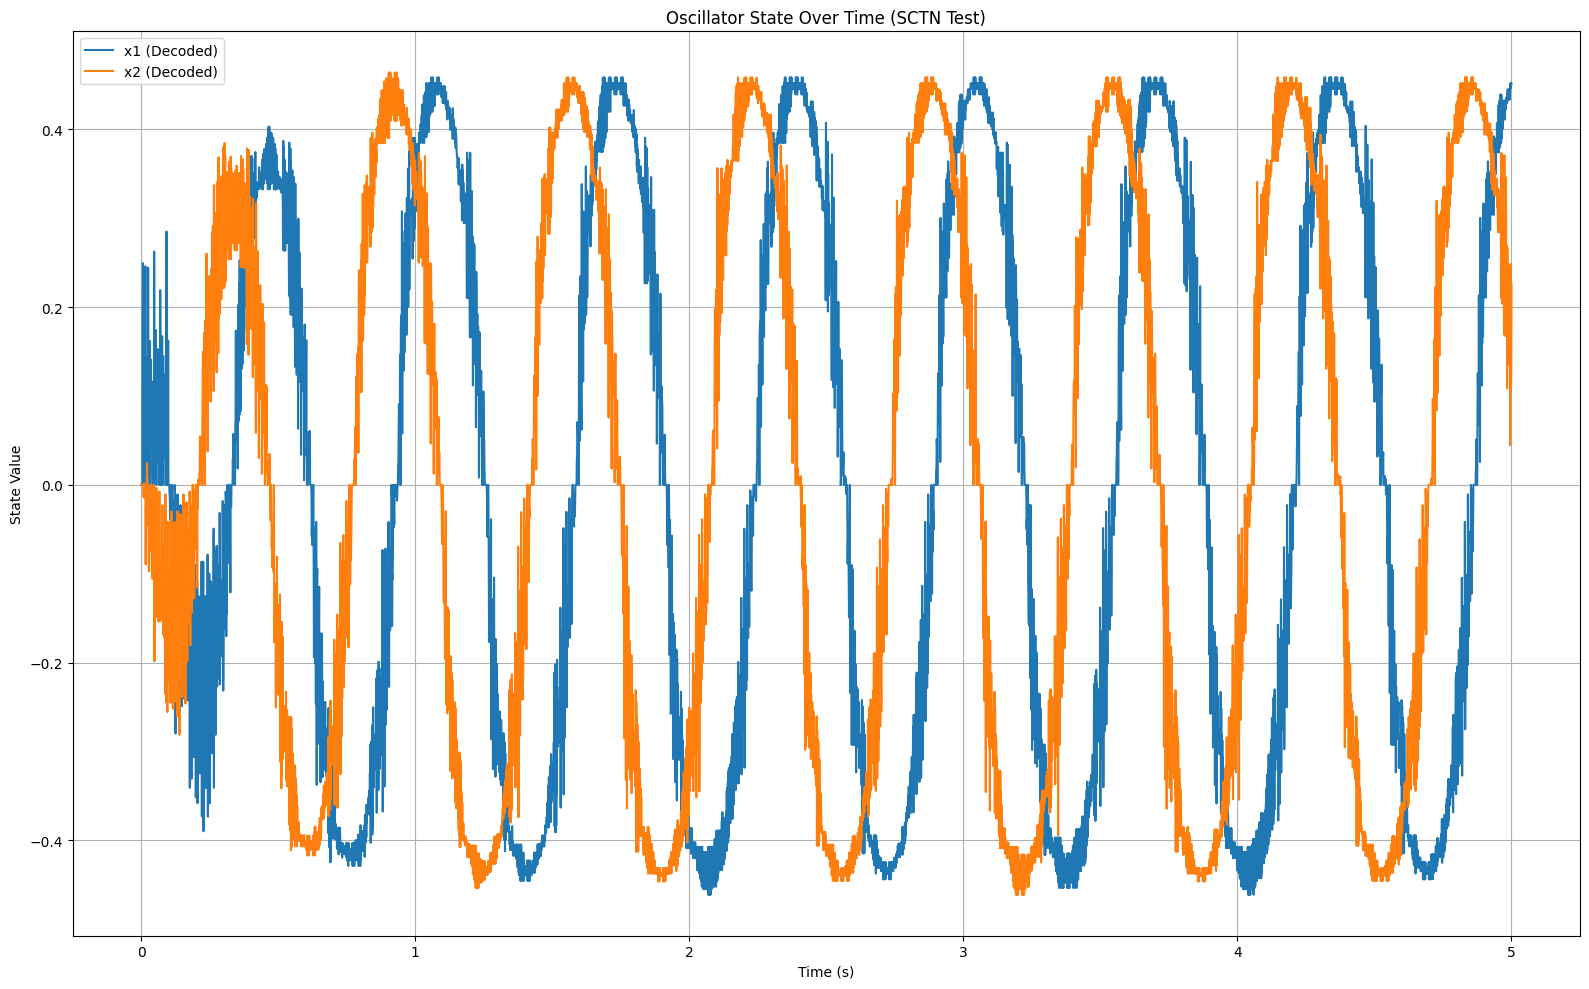

In [61]:
with FPGANetwork(label="SCTN_Oscillator_CustomSim") as net:
    inp = Node(input_func, label="input", add_to_container=False)
    net.add(inp)

    z1 = FPGAEnsemble(
        n_neurons=sim_n_neurons, dims_in=1, dims_out=1,
        radius=2.0,
        **sctn_params,
        max_rates=Uniform(80, 150),
        add_to_container=False
    )
    z2 = FPGAEnsemble(
        n_neurons=sim_n_neurons, dims_in=1, dims_out=1,
        radius=2.0,
        **sctn_params,
        max_rates=Uniform(80, 150),
        add_to_container=False
    )
    net.add(z1)
    net.add(z2)


    net.add(Connection(inp[0], z1, synapse=None, add_to_container=False))
    net.add(Connection(z1, z1, transform=sim_A[0, 0], synapse=sim_tau, add_to_container=False))
    net.add(Connection(z2, z1, transform=sim_A[0, 1], synapse=sim_tau, add_to_container=False))
    net.add(Connection(z1, z2, transform=sim_A[1, 0], synapse=sim_tau, add_to_container=False))
    net.add(Connection(z2, z2, transform=sim_A[1, 1], synapse=sim_tau, add_to_container=False))


print("\n--- Running Custom Simulator ---")
sim = FPGASimulator(net, sim_run_time, dt=sim_dt)
sim_data = sim.run()


t = sim.time_vec
x1_output = sim_data[z1].squeeze()
x2_output = sim_data[z2].squeeze()

plt.figure(figsize=(16, 10))
plt.plot(t, x1_output, label="x1 (Decoded)")
plt.plot(t, x2_output, label="x2 (Decoded)")
plt.title("Oscillator State Over Time (SCTN Test)")
plt.xlabel("Time (s)")
plt.ylabel("State Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()